In [101]:
# -------
# IMPORT LIBRAIRIES
# -------
import numpy as np
import pandas as pd
import plotly.express as px
from python_module.pricing_model import SABRModel
from python_module.tools import maximize_with_bounds

pd.options.display.max_rows = 999
pd.options.display.max_columns = 999
pd.options.display.float_format = '{:,.2f}'.format

In [102]:
# -------
# INPUTS
# -------

# Pricing parameters
F     = 5000
alpha = 0.15
beta  = 1.0
rho   = -0.5
nu    = 1.5
r     = 0
bd = 5

# Scenario parameters
scenario_min = -0.1
scenario_max = 0.1
scenario_step = 0.02

target_gamma = 10_000_000

In [103]:
# Scenario parameters
num = int((scenario_max-scenario_min)/0.01 + 1)
slide_to_compute = list(np.round(np.linspace(start=scenario_min, stop=scenario_max, num=num), 2))

In [104]:
strike_list = []
T = bd / 250
for delta in [-0.01]:
    option_type = 'call' if delta > 0 else 'put'
    K = SABRModel.solve_delta_strike(F=F, T=T, alpha=alpha, beta=beta, rho=rho, nu=nu, r=r, option_type=option_type, target_delta=delta)
    K = int(K)
    strike_list.append(K)
strike_list.append(F)
strike_list = sorted(strike_list)

In [128]:
# Option portfolio
market_data_list = list()
for K in strike_list:
    T = bd / 250
    option_type = 'call' if K >= F else 'put'
    market_pricing_results = SABRModel.compute_option(F, K, T, alpha, beta, rho, nu, r, option_type, slide_list=slide_to_compute)
    market_data_list.append({
        'symbol': f"{bd}T_{K}K_{option_type}",
        'option_type': option_type, 
        'time_to_maturity': bd, 
        'F':F, 'r': r, 'K': K, 'T': T, 'K/F': (K/F) - 1 ,**market_pricing_results})

market_data_df = pd.DataFrame(market_data_list)
market_data_df = market_data_df.set_index('symbol')
market_data_df = market_data_df.drop(0, axis=1)
market_data_df[0] = market_data_df['theta']

# Compute target quantity
market_data_df['gamma_cash'] = (market_data_df['gamma']*(F**2)) / 100
atm_symbol = market_data_df[market_data_df['K']==F].index[0]
qty = target_gamma / market_data_df.loc[atm_symbol, 'gamma_cash']
weights = -((market_data_df.loc[atm_symbol, 'theta']) / market_data_df['theta']) * qty
weights[atm_symbol] = qty

In [130]:
weights

symbol
5T_4757K_put    -78,414.22
5T_5000K_call    10,654.27
Name: theta, dtype: float64

In [132]:
market_data_df['vega']*weights

symbol
5T_4757K_put    -26,299.99
5T_5000K_call    30,053.44
dtype: float64

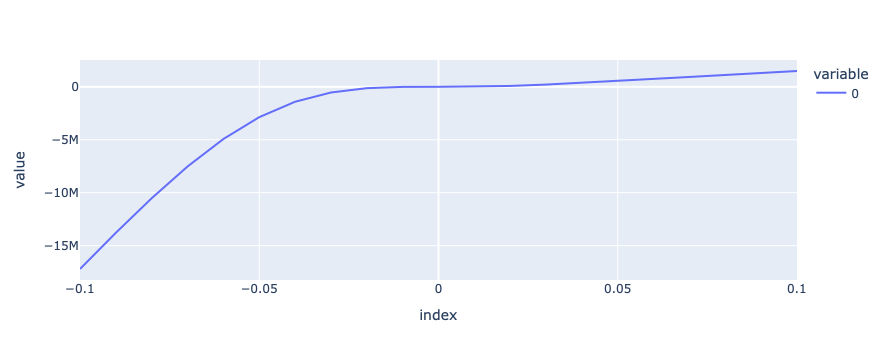

In [134]:
px.line(market_data_df.loc[:, slide_to_compute].multiply(weights, axis=0).sum(axis=0).sort_index())

In [109]:
market_data_df.loc[:, ['vega', 'theta', 'gamma_cash']].multiply(weights, axis=0).sum(axis=0)

vega           -5,693.59
theta          16,221.77
gamma_cash   -408,957.34
dtype: float64